# SETUP

The first part of the code sets up the pca_wavelet network, the training comes later. Most of this code comes from the original authors

In [83]:
import sys
sys.path.append('../segmentation_helper')

import tensorflow as tf
import keras
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import data_loader as dl
import model_broker as mb
import os

In [84]:
tf.keras.backend.set_floatx("float64")

In [85]:
dataset = "pets"
test_size=300
loader = dl.DataLoader(IMAGE_SIZE=128,dataset=dataset)
img_ds = loader.import_processed_img()
seg_ds = loader.import_processed_seg()
cardinality = int(img_ds.cardinality())

img_test = img_ds.take(test_size)
seg_test = seg_ds.take(test_size)
img_train = img_ds.skip(test_size)
seg_train = seg_ds.skip(test_size)    

In [86]:
def scaledtanh(x): 
    return tf.math.tanh(x*0.5)

def scaledatanh(x):
    return tf.math.atanh(x)*2.0

keep_percent 0.24992947786237735
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 6 keep_max 12.0
keep_channels 6
ufilts.shape (1, 1, 1, 27, 6)
end loop 64.0
Starting level 1
Completing 32.0
pca shape tf.Tensor([54 54], shape=(2,), dtype=int32)
keep_channels 13 keep_max 96.0
keep_channels 13
ufilts.shape (1, 1, 1, 54, 13)
end loop 32.0
Starting level 2
Completing 16.0
pca shape tf.Tensor([117 117], shape=(2,), dtype=int32)
keep_channels 29 keep_max 832.0
keep_channels 29
ufilts.shape (1, 1, 1, 117, 29)
end loop 16.0
Starting level 3
Completing 8.0
pca shape tf.Tensor([261 261], shape=(2,), dtype=int32)
keep_channels 65 keep_max 7424.0
keep_channels 65
ufilts.shape (1, 1, 1, 261, 65)
end loop 8.0
saving to: models/pets_img
out.shape (1, 8, 8, 65)
keep_percent 0.24992947786237735
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype:

array([[[0.69262552, 0.71781367, 0.76155508],
        [0.71057326, 0.72625953, 0.771909  ],
        [0.71057564, 0.73536116, 0.77416039],
        ...,
        [0.62020242, 0.72859132, 0.80774552],
        [0.56809223, 0.6901592 , 0.71563315],
        [0.46505725, 0.51409411, 0.5294745 ]],

       [[0.69430488, 0.70757556, 0.75192058],
        [0.68986964, 0.70555592, 0.74869317],
        [0.52143508, 0.53712136, 0.57241547],
        ...,
        [0.31167233, 0.31677154, 0.31952837],
        [0.31014478, 0.32910922, 0.340839  ],
        [0.38665462, 0.40670094, 0.40571529]],

       [[0.64814025, 0.65966892, 0.69567108],
        [0.6488291 , 0.65789437, 0.70128673],
        [0.65663344, 0.66905731, 0.70758224],
        ...,
        [0.37500575, 0.4474442 , 0.60752672],
        [0.17306314, 0.15756406, 0.13948472],
        [0.32297269, 0.400922  , 0.50831324]],

       ...,

       [[0.627451  , 0.63137257, 0.64891863],
        [0.59409374, 0.60481679, 0.62653524],
        [0.63633674, 0

sample.shape (128, 128, 3)
pred.shape (1, 8, 8, 65)
recon.shape (128, 128, 3)
sample.dtype <dtype: 'float64'>
recon[0].dtype <dtype: 'float64'>
np.prod(sample.shape) 49152
psnr =  10.524082577681376
ncc =  [[1.         0.40108723]
 [0.40108723 1.        ]]
sample[30:34,30:34,0] tf.Tensor(
[[0.61382556 0.64958882 0.66267908 0.63905627]
 [0.57931989 0.63768816 0.65419734 0.64157814]
 [0.56524777 0.62212014 0.6595282  0.63021654]
 [0.57054329 0.62714463 0.64846814 0.61396867]], shape=(4, 4), dtype=float64)
recon[30:34,30:34,0] tf.Tensor(
[[0.80842955 0.84818101 0.7891701  0.78881039]
 [0.83306316 0.83178097 0.77427136 0.74770019]
 [0.80841913 0.82182472 0.76878714 0.7702252 ]
 [0.78888588 0.79523736 0.79051722 0.79175992]], shape=(4, 4), dtype=float64)


(10.524082577681376,
 array([[1.        , 0.40108723],
        [0.40108723, 1.        ]]))

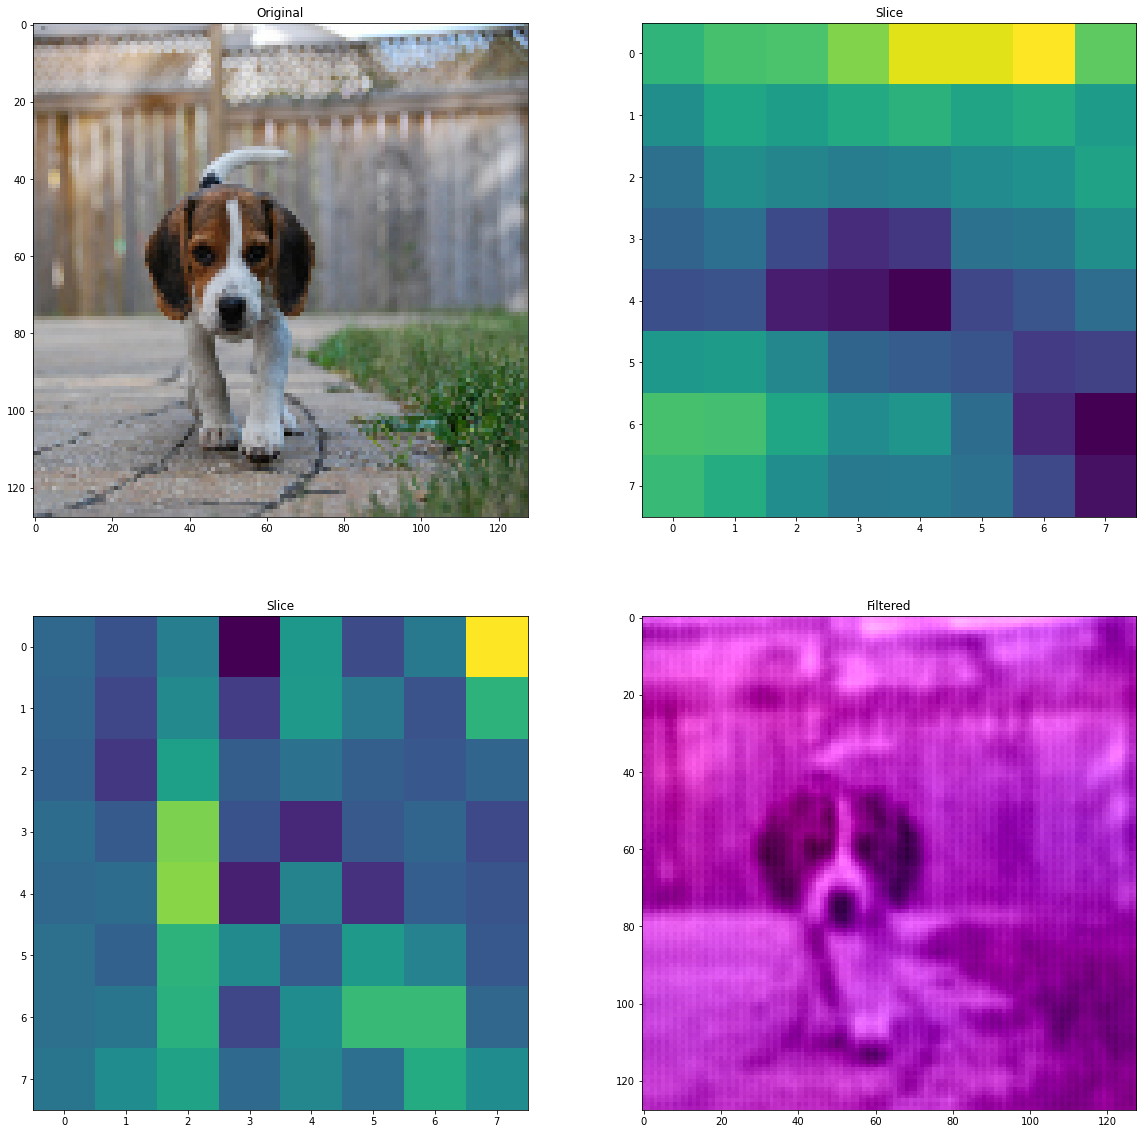

In [87]:
model_name = "img"
img_broker = mb.ModelBroker(trainset=img_train,
                            testset=img_test,
                            dirname=dataset+"_"+model_name,
                            keep_percent=0.1,
                            count=4,
                            sample_size=100,)
                            #activity_regularizer = scaledtanh,
                            #inverse_activity_regularizer=scaledatanh)

imghead,imginvhead = img_broker.build_model()
imghead,imginvhead = img_broker.load_model()    
img_broker.check_build(imghead,imginvhead,img_test)

keep_percent 0.24992947786237735
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 6 keep_max 12.0
keep_channels 6
ufilts.shape (1, 1, 1, 27, 6)
end loop 64.0
Starting level 1
Completing 32.0
pca shape tf.Tensor([54 54], shape=(2,), dtype=int32)
keep_channels 13 keep_max 96.0
keep_channels 13
ufilts.shape (1, 1, 1, 54, 13)
end loop 32.0
Starting level 2
Completing 16.0
pca shape tf.Tensor([117 117], shape=(2,), dtype=int32)
keep_channels 29 keep_max 832.0
keep_channels 29
ufilts.shape (1, 1, 1, 117, 29)
end loop 16.0
Starting level 3
Completing 8.0
pca shape tf.Tensor([261 261], shape=(2,), dtype=int32)
keep_channels 65 keep_max 7424.0
keep_channels 65
ufilts.shape (1, 1, 1, 261, 65)
end loop 8.0
saving to: models/pets_seg
out.shape (1, 8, 8, 65)
keep_percent 0.24992947786237735
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype:

array([[[0.30238086, 0.31059164, 0.26969808],
        [0.18383956, 0.18720967, 0.13997516],
        [0.463815  , 0.39022839, 0.42807931],
        ...,
        [0.13483647, 0.19829893, 0.08375484],
        [0.17012198, 0.24877141, 0.08378883],
        [0.2270101 , 0.29000509, 0.18154798]],

       [[0.3363401 , 0.32167396, 0.30889103],
        [0.39788005, 0.37250906, 0.44309896],
        [0.25939846, 0.24164729, 0.28150374],
        ...,
        [0.1493808 , 0.19986358, 0.08383454],
        [0.19145317, 0.25200483, 0.1373978 ],
        [0.19450444, 0.27459931, 0.14320594]],

       [[0.43378526, 0.41914973, 0.39175141],
        [0.53299224, 0.47432935, 0.43550929],
        [0.26091978, 0.16487557, 0.1553984 ],
        ...,
        [0.23294869, 0.31251511, 0.16703191],
        [0.05754849, 0.08229335, 0.0450236 ],
        [0.26319367, 0.31440577, 0.20727804]],

       ...,

       [[0.28939831, 0.31467333, 0.36658958],
        [0.20536776, 0.2491764 , 0.21404551],
        [0.20258646, 0

sample.shape (128, 128, 3)
pred.shape (1, 8, 8, 65)
recon.shape (128, 128, 3)
sample.dtype <dtype: 'float64'>
recon[0].dtype <dtype: 'float64'>
np.prod(sample.shape) 49152
psnr =  9.668873857334578
ncc =  [[1.         0.43354544]
 [0.43354544 1.        ]]
sample[30:34,30:34,0] tf.Tensor(
[[0.50044161 0.49902296 0.59842151 0.59518474]
 [0.56894892 0.71495318 0.52563024 0.66185015]
 [0.69433594 0.80745661 0.53973722 0.63036394]
 [0.52832729 0.53391856 0.67030823 0.52108586]], shape=(4, 4), dtype=float64)
recon[30:34,30:34,0] tf.Tensor(
[[0.65302637 0.68725703 0.67841856 0.7626355 ]
 [0.736208   0.7245566  0.73950286 0.77527923]
 [0.70398451 0.74237696 0.70222128 0.75011227]
 [0.73303284 0.74857443 0.72691251 0.7141897 ]], shape=(4, 4), dtype=float64)


(9.668873857334578,
 array([[1.        , 0.43354544],
        [0.43354544, 1.        ]]))

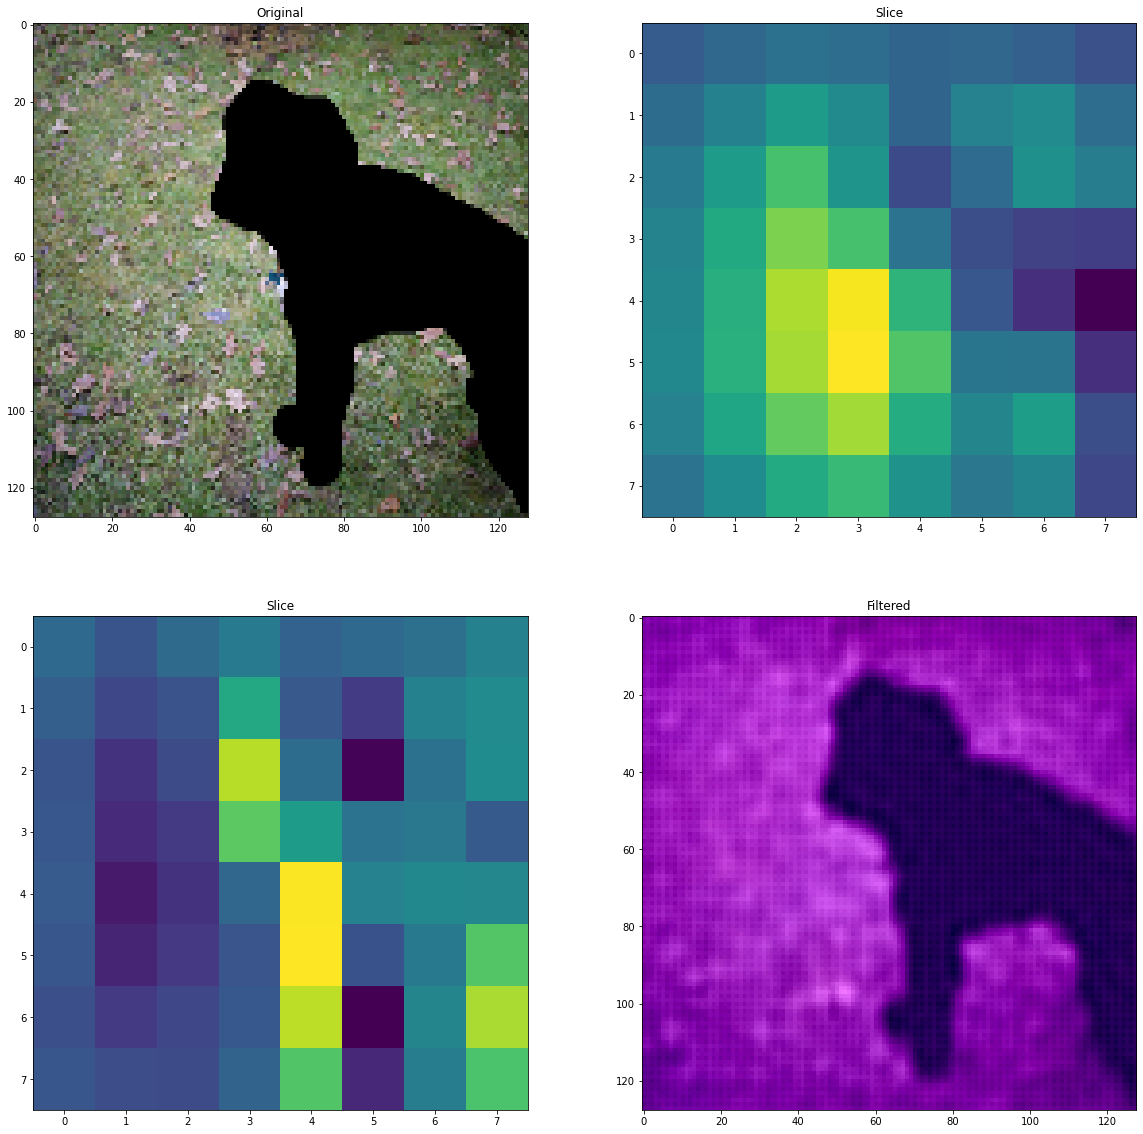

In [88]:
model_name = "seg"
seg_broker = mb.ModelBroker(trainset=seg_train,
                            testset=seg_test,
                            dirname=dataset+"_"+model_name,
                            keep_percent=0.1,
                            count=4,
                            sample_size=100)
                            #activity_regularizer = scaledtanh,
                            #inverse_activity_regularizer=scaledatanh)

seghead,seginvhead = seg_broker.build_model()
seghead,seginvhead = seg_broker.load_model()    
seg_broker.check_build(seghead,seginvhead,seg_test)

# Training

This is the loop used to find the variables to find A and b in y=Ax+b

In [89]:
imgflat = np.prod(imghead(next(iter(img_train))[0]).shape)
segflat = np.prod(seghead(next(iter(seg_train))[0]).shape)
end_shape = next(iter(seg_train))[0].shape
n = 0.0

xxt = np.zeros([imgflat])
yxt = np.zeros([segflat])
x = np.zeros([imgflat])
y = np.zeros([segflat]) 

bar = tqdm.notebook.tqdm(total = int(img_train.cardinality()))

for item in iter(zip(img_train,seg_train)):

    bar.update(1)

    image = item[0][0]
    segmentation = item[1][0]

    imgdecom = imghead(image)
    segdecom = seghead(segmentation)

    mat = tf.reshape(imgdecom,[-1])
    segmat = tf.reshape(segdecom,[-1])

    cov = tf.matmul([mat],[mat],transpose_a=True)
    xxt += cov
    segcov = tf.matmul([mat],[segmat],transpose_a=True)
    yxt += segcov
    x+=mat
    y+=segmat
    n += 1

  0%|          | 0/7049 [00:00<?, ?it/s]

## Calculating A and B

This section uses the values found in the training loop to calculate values for A and B

In [90]:
xxt = xxt - tf.matmul([x],[x],transpose_a=True)/n
yxt = yxt - tf.matmul([x],[y],transpose_a=True)/n

In [91]:
inverse_xxt = tf.linalg.pinv(xxt)

In [92]:
A = tf.linalg.matmul(inverse_xxt,yxt)

In [93]:
b = (y - tf.linalg.matvec(A,x,transpose_a=True))/n

In [94]:
def dice_coef(y_true, y_pred,smooth=1):
    y_true_f = tf.reshape(y_true,-1)
    y_pred_f =tf.reshape(y_pred,-1)
    intersection = tf.reduce_sum(y_true_f * y_pred_f,0)

    return float((2. * intersection+smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)+smooth))

In [95]:
def iou_coef(y_true, y_pred,smooth=1):
  intersection = tf.reduce_sum(y_true * y_pred, 0)
  union = tf.reduce_sum(y_true,0)+tf.reduce_sum(y_pred,0)-intersection
  iou = tf.reduce_mean((intersection+1) / (union+1), 0)
  return float(iou)

0.6902092675635276


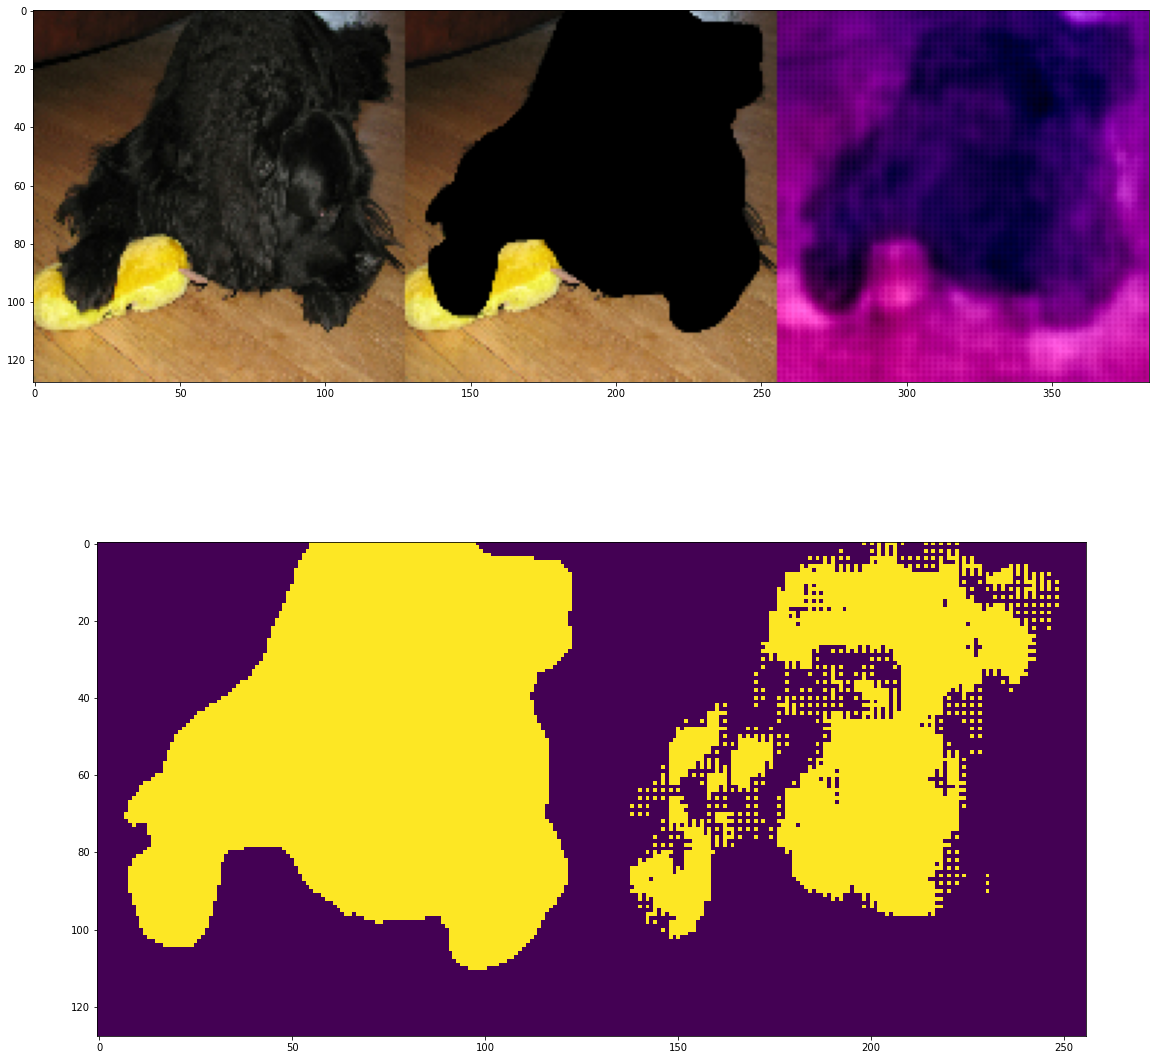

In [101]:
import random
threshold_intensity = 0.03
reconstruct = seghead(next(iter(seg_train))[0]).shape
skip = random.randint(0,300)
image,seg_base = next(iter(zip(img_train.skip(skip),seg_train.skip(skip))))
imgdecom = imghead(image[0])
imgdecom = tf.reshape(imgdecom,(1,-1))
segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
seg = seginvhead(tf.reshape(segdecom,(reconstruct)))

y_true = tf.cast(tf.reduce_mean(seg_base[0],2)==0,tf.float64)
y_pred = tf.cast(tf.reduce_mean(seg[0],2)<=threshold_intensity,tf.float64)
plt.subplot(2,1,1)
plt.imshow(np.hstack([image[0],seg_base[0],seg[0]]))
plt.subplot(2,1,2)
plt.rcParams["figure.figsize"]=(2,2)
plt.imshow(np.hstack([y_true,y_pred]))
print(dice_coef(y_true,y_pred))

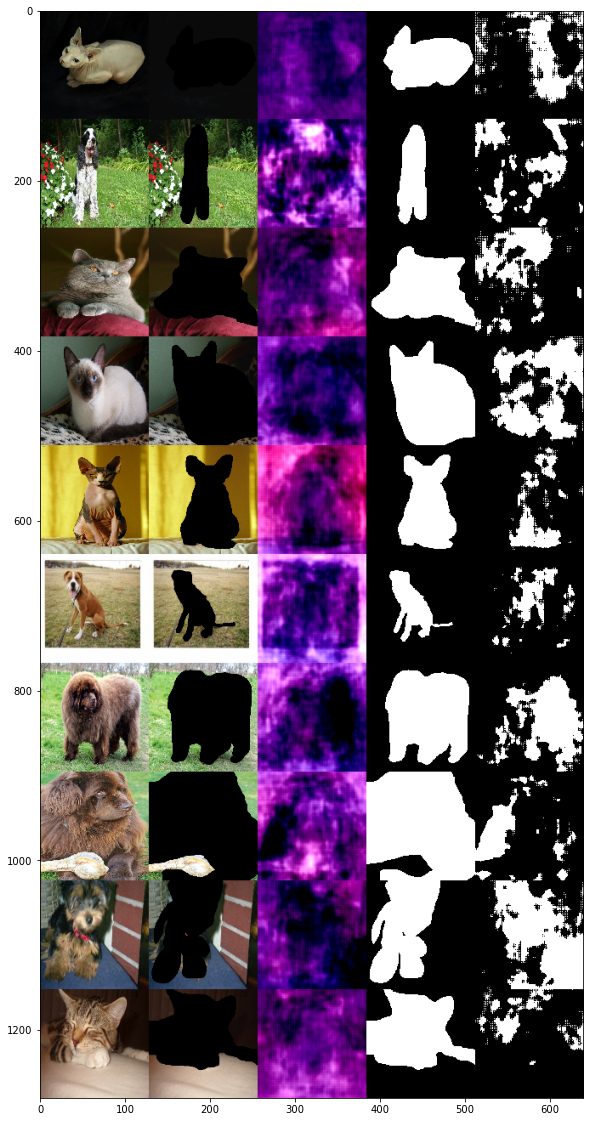

In [102]:
stacked_decom = []
for image,seg_base in iter(zip(img_test.take(10),seg_test.take(10))):
    imgdecom = imghead(image[0])
    imgdecom = tf.reshape(imgdecom,(1,-1))
    segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
    seg = seginvhead(tf.reshape(segdecom,(reconstruct)))
    y_true = tf.cast(tf.reduce_mean(seg_base[0],2)==0,tf.float64)
    y_pred = tf.cast(tf.reduce_mean(seg[0],2)<=threshold_intensity,tf.float64)
    stacked_decom.append(np.hstack([image[0],seg_base[0],seg[0],np.repeat(y_true,3).reshape(image[0].shape),np.repeat(y_pred,3).reshape(image[0].shape)]))
plt.rcParams["figure.figsize"]=(20,20)
plt.imshow(np.vstack(stacked_decom))

In [98]:

for split in ["train","test"]:
    if split == "train":
        img_ds, seg_ds = (img_train,seg_train)
    else:
        img_ds, seg_ds = (img_test,seg_test)
    n = int(seg_ds.cardinality())
    dice_coeff_vals = []
    for image,seg_base in iter(zip(img_ds, seg_ds)):
        imgdecom = imghead(image[0])
        imgdecom = tf.reshape(imgdecom,(1,-1))
        segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
        seg = seginvhead(tf.reshape(segdecom,(reconstruct)))
        y_true = tf.cast(tf.reduce_mean(seg_base[0],2)==0,tf.float64)
        y_pred = tf.cast(tf.reduce_mean(seg[0],2)<=threshold_intensity,tf.float64)
        dice_coeff_vals.append(dice_coef(y_true,y_pred))
    dice_coeff_mean = sum(dice_coeff_vals)/n
    dice_coeff_std = (sum([((x - dice_coeff_mean) ** 2) for x in dice_coeff_vals]) / n)**0.5
    np.save(f"PCWN_CONN_{dataset}_{split}",dice_coeff_vals)

KeyboardInterrupt: 